# Import Packages and Data

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import great_circle

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, KMeansSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

from src.classes import *

In [2]:
cc_df = pd.read_csv("data/credit_card_purchases_sampled.csv")

In [3]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50000 non-null  int64  
 1   trans_date_trans_time  50000 non-null  object 
 2   cc_num                 50000 non-null  int64  
 3   merchant               50000 non-null  object 
 4   category               50000 non-null  object 
 5   amt                    50000 non-null  float64
 6   first                  50000 non-null  object 
 7   last                   50000 non-null  object 
 8   gender                 50000 non-null  object 
 9   street                 50000 non-null  object 
 10  city                   50000 non-null  object 
 11  state                  50000 non-null  object 
 12  zip                    50000 non-null  int64  
 13  lat                    50000 non-null  float64
 14  long                   50000 non-null  float64
 15  ci

In [4]:
# Drop included index col
cc_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  50000 non-null  object 
 1   cc_num                 50000 non-null  int64  
 2   merchant               50000 non-null  object 
 3   category               50000 non-null  object 
 4   amt                    50000 non-null  float64
 5   first                  50000 non-null  object 
 6   last                   50000 non-null  object 
 7   gender                 50000 non-null  object 
 8   street                 50000 non-null  object 
 9   city                   50000 non-null  object 
 10  state                  50000 non-null  object 
 11  zip                    50000 non-null  int64  
 12  lat                    50000 non-null  float64
 13  long                   50000 non-null  float64
 14  city_pop               50000 non-null  int64  
 15  jo

In [6]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2020-06-03 12:43:29,581293083266,fraud_Reilly LLC,home,77.90,William,Thomas,M,39227 Mcpherson Shoals,Lahoma,...,-98.0727,1078,Podiatrist,1989-10-06,f3d6477a2e1bb93f4c1b18adf2a607d1,1370263409,36.566036,-97.237692,0,74644.0
1,2020-04-18 19:57:14,340953839692349,fraud_Hamill-D'Amore,health_fitness,47.78,Tyler,Wright,M,615 Clarke Spring Apt. 172,Warren,...,-82.9832,134056,"Doctor, hospital",1980-05-18,0fbb710e4a8d253580751528c7a2cd92,1366315034,42.837893,-83.228559,0,48370.0
2,2019-01-14 22:23:54,3595192916105588,"fraud_Kerluke, Considine and Macejkovic",misc_net,690.81,Dustin,Roberts,M,3283 James Station,Fayetteville,...,-79.0080,238602,"Scientist, research (maths)",1993-05-14,cc0ce65bebf95fd2b2f76b3f8d2c15f7,1326579834,35.439158,-78.609636,1,27521.0
3,2019-08-02 09:31:48,4390966588600992777,fraud_Torp-Labadie,gas_transport,65.85,Kyle,Simmons,M,8149 Harris Divide,Oklahoma City,...,-97.5583,640470,Advertising copywriter,1966-06-24,d5b4400db9755821f60fa0bec602b2d2,1343899908,36.531040,-97.737859,0,74640.0
4,2019-01-14 16:03:53,36485887555770,"fraud_Reichert, Shanahan and Hayes",shopping_net,67.11,Michael,Gross,M,230 Ryan Tunnel Apt. 025,Fulton,...,-82.8342,267,Facilities manager,2005-01-29,6270f5ee1b11d2354d6828508860f1ed,1326557033,41.189226,-81.864998,0,44280.0


# Exploratory Data Analysis and Cleaning

## Column Re-labeling

In [7]:
# Cast cc_num to string
cc_df['cc_num'] = cc_df['cc_num'].astype(str)

# Cast trans_date_trans_time to datetime
cc_df['trans_date_trans_time'] = pd.to_datetime(cc_df['trans_date_trans_time'])
cc_df['dob'] = pd.to_datetime(cc_df['dob'])

# Rename column
cc_df.rename(columns={'trans_date_trans_time' : 'timestamp'}, inplace=True)

# Drop column
cc_df.drop(['unix_time'], axis=1, inplace=True)

## Missingness

The only column with missing values is 'merch_zipcode'. Lets investigate this column to see the effect dropping the columns would have. 

In [8]:
# Calculate the total number of rows
total_rows = cc_df.shape[0]

# Calculate the number of non-null merch_zipcode values
non_null_merch_zipcode = cc_df['merch_zipcode'].notnull().sum()

# Calculate the number of missing merch_zipcode values
missing_merch_zipcode = total_rows - non_null_merch_zipcode

# Calculate the percentage of missing values
percentage_missing = (missing_merch_zipcode / total_rows) * 100

# Display the percentage of missing values
print(f"Percentage of merch_zipcode values that are missing: {percentage_missing:.2f}%")

Percentage of merch_zipcode values that are missing: 15.07%


Given that ~15.11% of the merchants zipcode are missing, dropping this many rows is difficult to do. But, there will still be 1.1 million transactions. 

When the model is being run, if the merchant zipcode is not an important feature, this decision will be revisited. 

In [9]:
# Drop NaNs
cc_df.dropna(subset=['merch_zipcode'], inplace=True)

# Cast zip to string
cc_df['merch_zipcode'] = cc_df['merch_zipcode'].astype(str)

## Numerical Columns

In [10]:
cc_df.describe()

,timestamp,amt,zip,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
count,42464,42464.000000,42464.000000,42464.000000,42464.000000,4.246400e+04,42464,42464.000000,42464.000000,42464.000000
mean,2019-10-02 15:50:25.013799936,136.132126,46575.423370,38.595645,-88.780103,8.737273e+04,1973-03-04 11:51:47.611152992,38.601349,-88.784797,0.149845
min,2019-01-01 00:17:40,1.000000,1257.000000,20.027100,-155.488000,2.300000e+01,1924-10-30 00:00:00,19.399206,-156.118071,0.000000
25%,2019-06-02 16:48:16.750000128,11.947500,24070.000000,35.058300,-95.350900,8.040000e+02,1961-12-05 00:00:00,35.175649,-95.421944,0.000000
50%,2019-10-02 03:56:53,53.620000,45801.000000,39.371600,-86.545700,2.501000e+03,1974-12-24 00:00:00,39.369549,-86.605711,0.000000
75%,2020-01-30 21:56:41.750000128,106.400000,68463.000000,41.603000,-79.808900,1.886275e+04,1986-11-24 00:00:00,41.704286,-79.766672,0.000000
max,2020-06-21 11:59:45,9999.390000,99323.000000,48.887800,-67.950300,2.906700e+06,2005-01-29 00:00:00,49.116921,-67.027467,1.000000
std,NaN,256.452379,25996.838552,4.551974,12.375770,2.979376e+05,NaN,4.555899,12.372878,0.356923


### Timestamp

When the fraudulent transactions occur could contain valuable information for the models. As such, lets expand out the timestamp to provide more information. 

In [11]:
# Expand the timestamp column
cc_df['hour'] = cc_df['timestamp'].dt.hour
cc_df['day_of_week'] = cc_df['timestamp'].dt.dayofweek
cc_df['month'] = cc_df['timestamp'].dt.month
cc_df['is_weekend'] = cc_df['timestamp'].dt.dayofweek >= 5

# Create time of day categories
def categorize_time_of_day(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

cc_df['time_of_day'] = cc_df['hour'].apply(categorize_time_of_day)

# Drop the original timestamp if not needed
cc_df.drop(columns=['timestamp'], inplace=True)

### Customer and Merchant Longitude and Latitude

In [12]:
# Calculate distance feature
def calculate_distance(row):
    transaction_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return great_circle(transaction_location, merchant_location).miles

# Apply distance calculation
cc_df['distance_to_merchant'] = cc_df.apply(calculate_distance, axis=1)

# Drop the individual location columns
cc_df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

## Categorical Columns

### Customer Count 

In [13]:
print(f"There are {cc_df['cc_num'].nunique()} unique customers in the dataset.")

There are 980 unique customers in the dataset.


### Merchant

In [14]:
cc_df['merchant'].value_counts()

merchant
fraud_Kilback LLC         159
fraud_Boyer PLC           144
fraud_Cormier LLC         142
fraud_Kuhn LLC            123
fraud_Schumm PLC          116
                         ... 
fraud_Johnston-Casper      19
fraud_Treutel-King         18
fraud_Smitham-Schiller     18
fraud_Bednar Inc           17
fraud_Kris-Kertzmann       14
Name: count, Length: 693, dtype: int64

It appears that all of the entires begin with 'fraud_'. If they do, lets remove the extraneous wording. 

In [15]:
# Investigate the column
all_fraud = cc_df['merchant'].str.startswith('fraud_').all()
print(f"Do all merchants start with 'fraud_'? {all_fraud}")

# Remove the text at the beginning of each entry
cc_df['merchant'] = cc_df['merchant'].str.replace('^fraud_', '', regex=True)

# Check work
cc_df['merchant'].value_counts()

Do all merchants start with 'fraud_'? True


merchant
Kilback LLC         159
Boyer PLC           144
Cormier LLC         142
Kuhn LLC            123
Schumm PLC          116
                   ... 
Johnston-Casper      19
Treutel-King         18
Smitham-Schiller     18
Bednar Inc           17
Kris-Kertzmann       14
Name: count, Length: 693, dtype: int64

Given the high cardinality of the column and that there is a category column that labels the transaction in a more conventional sense, the merchant column will be dropped. 

If the models performance does not reach an adequate level, the inclusion of this column will be revisted. 

In [16]:
# Drop column
cc_df.drop(['merchant'], axis=1, inplace=True)

### Category

/var/folders/1m/xn6n7t396ts_bvsd56hkwp4c0000gn/T/ipykernel_4994/2628249180.py:9: UserWarning: 
The palette list has fewer values (10) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='category', y='count', data=category_df, hue='category', palette=sns.color_palette("colorblind"))


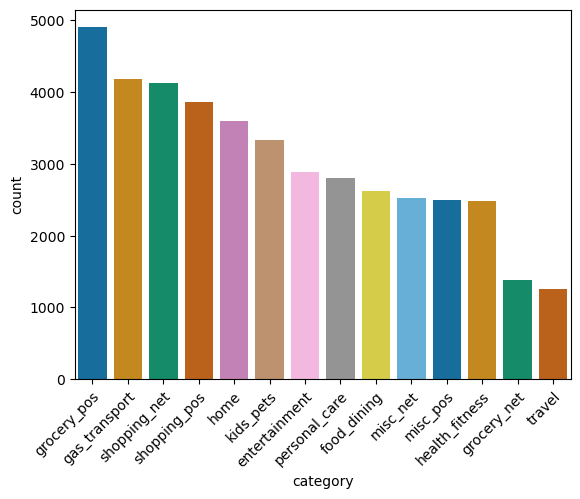

In [17]:
# Create category counts
category_value_counts = cc_df['category'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = category_value_counts.reset_index()
category_df.columns = ['category', 'count']

# Plot
sns.barplot(x='category', y='count', data=category_df, hue='category', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Gender

/var/folders/1m/xn6n7t396ts_bvsd56hkwp4c0000gn/T/ipykernel_4994/1681067231.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x='gender', y='count', data=category_df, hue='gender', palette=sns.color_palette("colorblind"))


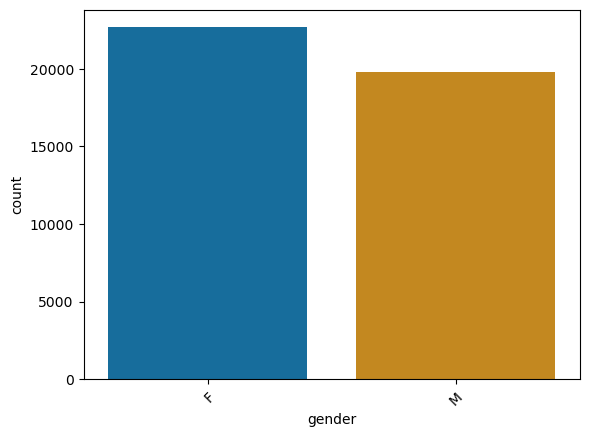

In [18]:
# Create category counts
gender_value_counts = cc_df['gender'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = gender_value_counts.reset_index()
category_df.columns = ['gender', 'count']

# Plot
sns.barplot(x='gender', y='count', data=category_df, hue='gender', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Job

In [19]:
# Covert the rows to lowercase and remove whitespace
cc_df['job'] = cc_df['job'].str.lower().str.strip()

In [20]:
# Define a mapping for collapsing job titles with unique titles
job_mapping = {
    # Engineering and Technology
    'engineering and technology': [
        'engineer', 'technical', 'aeronautical engineer', 'biomedical engineer', 'engineering geologist',
        'environmental engineer', 'it consultant', 'multimedia programmer', 'programmer', 'technology',
        'electronics engineer', 'naval architect', 'materials engineer', 'mining engineer', 'mechanical engineer',
        'chemical engineer', 'energy engineer', 'electrical engineer', 'drilling engineer', 'production engineer',
        'engineer, broadcasting (operations)', 'maintenance engineer', 'structural engineer', 'water engineer',
        'petroleum engineer', 'hydrologist', 'systems analyst', 'manufacturing systems engineer', 'building services engineer',
        'civil engineer, contracting', 'communications engineer', 'engineer, automotive', 'engineer, control and instrumentation',
        'physiotherapist', 'engineer, production', 'engineer, biomedical', 'engineer, mining', 'technical brewer', 
        'manufacturing engineer', 'engineer, electronics', 'engineer, petroleum', 'engineer, agricultural', 'engineer, land',
        'engineer, aeronautical', 'engineer, civil (contracting)', 'control and instrumentation engineer', 'network engineer',
        'broadcast engineer', 'data scientist', 'applications developer', 'programmer, multimedia', 'programmer, applications',
        'technical sales engineer', 'telecommunications researcher', 'industrial/product designer', 'seismic interpreter',
        'environmental health practitioner', 'software engineer', 'site engineer', 'make', 'metallurgist',
        'product/process development scientist', 'engineer, technical sales', 'engineer, communications', 'designer, multimedia',
        'garment/textile technologist', 'mudlogger', 'pilot, airline', 'contractor', 'energy manager', 'database administrator',
        'geophysicist/field seismologist', 'armed forces logistics/support/administrative officer', 'intelligence analyst',
        'architectural technologist', 'design engineer', 'armed forces technical officer', 'contracting civil engineer',
    ],
    
    # Medical and Healthcare
    'medical and healthcare': [
        'medical professional', 'psychologist', 'psychotherapist', 'psychotherapist, child', 'psychologist, clinical',
        'psychiatrist', 'radiographer, diagnostic', 'radiographer, therapeutic', 'physiological scientist', 'health physicist',
        'medical physicist', 'occupational therapist', 'counsellor', 'therapist', 'nutritionist', 'pharmacologist', 'paramedic',
        'pathologist', 'immunologist', 'podiatrist', 'chiropodist', 'dance movement psychotherapist', 'hospital doctor',
        'scientist, audiological', 'toxicologist', 'private music teacher', 'forensic psychologist', 'child psychotherapist',
        'learning disability nurse', 'dispensing optician', 'health and safety adviser', 'mental health nurse', 'phytotherapist',
        'biomedical scientist', 'community pharmacist', 'nutritional therapist', 'clinical research associate', 'clinical biochemist',
        'osteopath', 'orthoptist', 'medical technical officer', 'veterinary surgeon', 'psychologist, forensic', 'surgeon',
        'exercise physiologist', 'occupational psychologist', 'medical sales representative', 'cytogeneticist', 'occupational hygienist',
        'counselling psychologist', 'psychologist, counselling', 'fisheries officer', 'physiotherapist', 'psychologist, sport and exercise',
        'pharmacist, community', 'psychiatric nurse', 'doctor, general practice', 'nurse, children\'s', 'paediatric nurse',
        'therapist, occupational', 'medical secretary', 'diagnostic radiographer', 'therapist, sports', 'therapist, drama',
        'therapist, horticultural', 'therapist, music', 'oncologist', 'embryologist, clinical', 'neurosurgeon', 'pharmacist, hospital',
        'optometrist', 'health visitor', 'clinical psychologist', 'herbalist', 'acupuncturist', 'homeopath', 'animal nutritionist',
        'general practice doctor', 'doctor, hospital', 'hospital pharmacist', 'nurse, mental health', 'therapist, art',
        'health promotion specialist', 'counselling psychologist', 'clinical psychologist', 'animal technologist',
        'horticultural therapist', 'sport and exercise psychologist', 'ambulance person',
    ],
    
    # Education and Research
    'education and research': [
        'teacher', 'lecturer', 'research scientist', 'academic librarian', 'educator', 'education officer', 
        'training and development officer', 'higher education careers adviser', 'secondary school teacher', 'early years teacher',
        'further education lecturer', 'learning mentor', 'science writer', 'outdoor activities/education manager',
        'archaeologist', 'assistant professor', 'professor emeritus', 'conservator, museum/gallery', 'museum/gallery exhibitions officer',
        'librarian, academic', 'teacher, special educational needs', 'education officer, museum', 'research scientist (physical sciences)',
        'education officer, community', 'research officer, trade union', 'research officer, political party', 'museum education officer',
        'educational psychologist', 'associate professor', 'tefl teacher', 'english as a second language teacher',
        'english as a foreign language teacher', 'private music teacher', 'sub', 'librarian, public', 'special educational needs teacher',
        'teacher, early years/pre', 'teacher, secondary school', 'teacher, english as a foreign language', 'lecturer, higher education',
        'education administrator', 'teaching laboratory technician', 'community education officer', 'primary school teacher',
        'teacher, adult education', 'researcher', 'curriculum developer', 'higher education administrator', 'program evaluator',
        'academic advisor', 'education policy analyst', 'training and development manager', 'instructional designer',
        'careers information officer', 'programme researcher, broadcasting/film/video', 'field trials officer',
        'armed forces training and education officer', 'administrator, education', 'special educational needs teacher',
        'social researcher', 'lexicographer', 'herpetologist', 'archivist', 'careers adviser', 'interpreter'
    ],
    
    # Arts, Media, and Design
    'arts, media, and design': [
        'designer', 'artist', 'media planner', 'advertising account planner', 'copywriter, advertising', 'journalist',
        'film/video editor', 'radio producer', 'television/film/video producer', 'music tutor', 'art therapist',
        'designer, television/film set', 'print designer', 'multimedia artist', 'exhibition designer', 'magazine features editor',
        'clothing/textile technologist', 'musician', 'producer, television/film/video', 'photographer', 'video editor',
        'stage manager', 'producer, radio', 'radio broadcast assistant', 'television production assistant', 'press photographer',
        'broadcast presenter', 'camera operator', 'set designer', 'theatre manager', 'theatre director', 'curator',
        'press photographer', 'television floor manager', 'exhibitions officer, museum/gallery', 'editor, commissioning',
        'editor, film/video', 'production assistant, radio', 'media buyer', 'music therapist', 'interior and spatial designer',
        'textile designer', 'glass blower/designer', 'arts development officer', 'community arts worker', 'designer, ceramics/pottery',
        'fine artist', 'designer, industrial/product', 'designer, exhibition/display', 'designer, jewellery', 'copy',
        'designer, furniture', 'designer, interior/spatial', 'animator', 'illustrator', 'special effects artist',
        'art gallery manager', 'visual merchandiser', 'gaffer', 'colour technologist', 'bookseller', 'magazine journalist',
        'editor, magazine features', 'programmer, multimedia', 'product designer', 'fashion designer', 'jewellery designer',
        'environmental education officer', 'writer', 'ceramics designer', 'architect', 'presenter, broadcasting',
        'conservator, furniture', 'broadcast journalist',
    ],
    
    # Business and Management
    'business and management': [
        'chief executive officer', 'chief financial officer', 'chief operating officer', 'chief technology officer',
        'chief strategy officer', 'manager', 'business consultant', 'management consultant', 'sales professional',
        'marketing', 'public relations', 'human resources officer', 'operations manager', 'executive', 'facilities manager',
        'purchasing manager', 'product manager', 'chief marketing officer', 'call centre manager', 'buyer, industrial',
        'consulting and advisory', 'production manager', 'sales executive', 'sales professional, it', 'health service manager',
        'systems developer', 'it trainer', 'business analyst', 'public relations account executive', 'retail merchandiser',
        'retail manager', 'logistics and distribution manager', 'charity fundraiser', 'human resources consultant',
        'commercial manager', 'marketing executive', 'sales promotion account executive', 'business development manager',
        'project manager', 'account manager', 'hr manager', 'business owner', 'management accountant', 'financial planner',
        'investment banker', 'investment analyst', 'accountant', 'credit controller', 'mortgage adviser', 'treasury analyst',
        'real estate agent', 'stockbroker', 'business adviser', 'company director', 'trading standards officer', 'mortgage broker',
        'business manager', 'public affairs consultant', 'external auditor', 'tax adviser', 'accounting technician',
        'non-profit manager', 'campaign manager', 'marketing manager', 'accountancy manager', 'management analyst',
        'strategic planner', 'business development executive', 'director, corporate affairs', 'director, marketing',
        'business intelligence analyst', 'business operations manager', 'commercial director', 'communications manager',
        'director of operations', 'financial analyst', 'insurance underwriter', 'management consultant',
        'financial adviser', 'chartered public finance accountant', 'quantity surveyor', 'surveyor, land/geomatics',
        'prison officer', 'pensions consultant', 'comptroller', 'land/geomatics surveyor', 'race relations officer',
        'financial trader', 'building surveyor', 'scientist, research (maths)', 'scientist, marine', 'claims inspector/assessor',
        'scientist, biomedical', 'senior tax professional/tax inspector', 'dealer', 'development worker, community',
        'operations geologist', 'barrister\'s clerk', 'geoscientist', 'lecturer, further education', 'historic buildings inspector/conservation officer',
        'chartered loss adjuster', 'travel agency manager', 'commercial/residential surveyor', 'tree surgeon', 'futures trader',
        'development worker, international aid', 'tax inspector', 'journalist, newspaper', 'heritage manager', 'press sub',
        'fitness centre manager', 'amenity horticulturist', 'administrator', 'equality and diversity officer', 'physicist, medical',
        'commercial horticulturist', 'insurance risk surveyor', 'advice worker', 'building control surveyor', 'risk analyst',
        'wellsite geologist', 'tourist information centre manager', 'leisure centre manager', 'politician\'s assistant',
        'waste management officer', 'secretary/administrator', 'administrator, local government', 'trade mark attorney',
        'investment banker, corporate', 'arboriculturist', 'museum/gallery conservator', 'statistician', 'surveyor, minerals',
        'geologist, wellsite', 'optician, dispensing', 'administrator, charities/voluntary organisations', 'furniture designer',
        'sports development officer', 'patent attorney', 'market researcher', 'farm manager', 'research scientist (life sciences)',
        'operational researcher', 'land', 'warden/ranger', 'regulatory affairs officer', 'aid worker', 'landscape architect',
        'web designer', 'insurance broker', 'accountant, chartered public finance', 'pension scheme manager', 'research scientist (maths)',
        'surveyor, rural practice', 'surveyor, mining', 'theme park manager', 'retail banker', 'scientist, research (physical sciences)',
        'conservation officer, historic buildings', 'equities trader', 'emergency planning/management officer', 'field seismologist',
        'corporate investment banker', 'geologist, engineering', 'licensed conveyancer', 'cartographer', 'scientist, physiological',
        'records manager', 'rural practice surveyor', 'planning and development surveyor', 'chartered accountant', 'quarry manager',
        'town planner', 'horticulturist, commercial', 'insurance claims handler', 'advertising copywriter', 'volunteer coordinator',
        'furniture conservator/restorer', 'public house manager', 'sports administrator', 'civil service fast streamer', 'designer, textile',
        'event organiser', 'community development worker', 'hydrographic surveyor', 'commissioning editor', 'air broker', 'cabin crew',
        'engineer, drilling', 'engineer, building services', 'biochemist, clinical', 'economist', 'engineer, maintenance',
        'plant breeder/geneticist', 'chartered legal executive (england and wales)', 'chief of staff', 'information systems manager',
        'engineer, manufacturing', 'scientist, clinical (histocompatibility and immunogenetics)', 'social research officer, government',
        'minerals surveyor', 'scientist, research (medical)', 'research scientist (medical)', 'analytical chemist', 'clinical cytogeneticist',
        'chemist, analytical', 'loss adjuster, chartered', 'teacher, primary school', 'production assistant, television',
        'horticultural consultant', 'engineer, materials', 'air cabin crew', 'investment banker, operational',
        'civil service administrator', 'solicitor, scotland', 'public librarian', 'restaurant manager, fast food',
        'geneticist, molecular', 'estate manager/land agent', 'water quality scientist', 'surveyor, hydrographic', 'dancer',
        'television camera operator', 'accountant, chartered certified', 'tour manager', 'nature conservation officer',
        'personnel officer', 'administrator, arts', 'local government officer', 'engineer, structural', 'buyer, retail',
        'engineer, site', 'location manager', 'information officer', 'merchandiser, retail', 'industrial buyer', 'ship broker',
        'forest/woodland manager', 'accountant, chartered'
    ],
    
    # Law and Public Service
    'law and public service': [
        'lawyer', 'solicitor', 'barrister', 'legal executive', 'paralegal', 'legal secretary', 'notary public',
        'probate practitioner', 'conveyancer', 'legal adviser', 'police officer', 'firefighter', 'paramedic', 'social worker',
        'probation officer', 'criminologist', 'community support worker', 'coroner', 'legal advisor', 'court usher', 'diplomat',
        'human rights officer', 'immigration officer', 'military officer', 'intelligence officer', 'government administrator',
        'policy analyst', 'legal consultant', 'legal researcher', 'environmental health officer', 'charity officer',
        'emergency planning officer', 'armed forces', 'political researcher', 'researcher, policy', 'public affairs officer',
        'advocate', 'community safety officer', 'law enforcement officer', 'social services manager', 'public services manager',
        'community worker', 'legal compliance officer', 'adviser, business', 'investigator', 'public relations officer',
        'tax adviser', 'trade union representative', 'public policy consultant', 'caseworker', 'data protection officer',
        'civil service', 'foreign service officer', 'human resources officer', 'court clerk', 'legislative assistant',
        'nonprofit administrator', 'social care worker', 'public health inspector', 'social researcher', 'court interpreter',
        'social welfare officer', 'regulatory affairs specialist', 'senior policy advisor', 'legal assistant', 'tax consultant',
        'legal analyst', 'compliance officer', 'charity fundraiser', 'victim support officer', 'police investigator',
        'court reporter', 'forensic accountant', 'legal administrator', 'legal officer', 'compliance manager', 'community organizer',
        'political adviser', 'social justice advocate', 'human resources manager', 'regulatory officer'
    ],
    
    # Science and Environment
    'science and environment': [
        'scientist', 'environmental scientist', 'biologist', 'ecologist', 'geologist', 'chemist', 'physicist', 'climatologist',
        'meteorologist', 'marine biologist', 'zoologist', 'environmental consultant', 'conservationist', 'research scientist',
        'environmental engineer', 'wildlife biologist', 'forensic scientist', 'hydrologist', 'astrobiologist', 'geochemist',
        'oceanographer', 'environmental educator', 'biochemist', 'environmental policy analyst', 'environmental health specialist',
        'environmental protection officer', 'environmental compliance specialist', 'earth scientist', 'toxicologist',
        'forensic ecologist', 'environmental risk assessor', 'environmental manager', 'science communicator', 'nature reserve manager',
        'agronomist', 'environmental researcher', 'sustainable development consultant', 'geophysicist', 'scientific researcher',
        'agriculture consultant', 'forestry officer', 'environmental analyst', 'climate scientist', 'wildlife conservationist',
        'environmental microbiologist', 'environmental geologist', 'renewable energy consultant', 'agricultural scientist',
        'environmental technician', 'sustainable energy specialist', 'science educator', 'aquatic biologist', 'applied scientist',
        'soil scientist', 'biodiversity officer', 'scientific advisor', 'scientific policy advisor', 'research and development scientist',
        'field biologist', 'geotechnical engineer', 'climate change analyst', 'sustainability consultant', 'environmental field officer',
        'natural resource manager', 'biological technician', 'environmental health scientist', 'energy auditor', 'environmental compliance officer',
        'marine scientist', 'conservation scientist', 'environmental assessment specialist', 'hydrogeologist', 'scientific laboratory technician',
        'urban planner', 'conservation biologist', 'waste management specialist', 'audiological scientist', 'operations geologist',
    ],
    
    # Transportation and Logistics
    'transportation and logistics': [
        'logistics manager', 'transport planner', 'supply chain manager', 'transportation coordinator', 'freight forwarder',
        'shipment coordinator', 'distribution manager', 'traffic engineer', 'warehouse manager', 'delivery driver',
        'logistics coordinator', 'transport operator', 'road transport manager', 'air cargo agent', 'sea freight coordinator',
        'logistics analyst', 'import/export coordinator', 'fleet manager', 'route planner', 'transport manager', 'cargo handler',
        'supply chain analyst', 'shipping manager', 'inventory manager', 'logistics consultant', 'transportation specialist',
        'logistics director', 'supply chain director', 'transportation analyst', 'transport operations manager', 'logistics technician',
        'transportation planner', 'transportation manager', 'logistics support officer', 'warehouse operative', 'transit coordinator',
        'shipping coordinator', 'distribution coordinator', 'supply chain consultant', 'traffic manager', 'freight manager',
        'airline operations manager', 'railway manager', 'logistics project manager', 'warehouse supervisor', 'transit planner',
        'import/export manager', 'logistics executive', 'supply chain executive', 'fleet coordinator', 'transportation coordinator',
        'traffic coordinator', 'road transport coordinator', 'port operations manager', 'sea cargo agent', 'air freight manager',
        'transportation operations coordinator', 'rail transport manager', 'distribution executive', 'transportation supervisor',
    ],
    
    # Agriculture and Rural Affairs
    'agriculture and rural affairs': [
        'farmer', 'agricultural consultant', 'farm manager', 'agricultural engineer', 'agronomist', 'landscaper', 'horticulturalist',
        'forester', 'land agent', 'agriculture adviser', 'veterinary surgeon', 'animal husbandry', 'plant breeder', 'soil scientist',
        'rural surveyor', 'veterinary technician', 'crop scientist', 'animal nutritionist', 'organic farmer', 'agricultural scientist',
        'environmental scientist', 'rural development officer', 'poultry farmer', 'dairy farmer', 'crop consultant', 'landscape architect',
        'agriculture technician', 'rural affairs consultant', 'fisheries officer', 'forestry consultant', 'land management officer',
        'arborist', 'agricultural project manager', 'rural planner', 'horticulture manager', 'animal care technician', 'plant pathologist',
        'livestock manager', 'sustainable agriculture consultant', 'pest control advisor', 'land use planner', 'organic agriculture consultant',
        'rural support officer', 'farm worker', 'agricultural educator', 'sustainable land manager', 'aquaculture manager',
        'soil conservationist', 'agriculture policy advisor', 'organic horticulturist', 'plant scientist', 'livestock advisor',
        'animal behaviorist', 'rural business manager', 'farm consultant', 'agriculture researcher', 'plant protection advisor',
    ],
    
    # Construction and Architecture
    'construction and architecture': [
        'architect', 'construction manager', 'building surveyor', 'quantity surveyor', 'civil engineer', 'site manager',
        'project manager', 'structural engineer', 'quantity surveyor', 'building services engineer', 'architectural technician',
        'urban planner', 'interior designer', 'landscape architect', 'contractor', 'construction estimator', 'construction project manager',
        'building inspector', 'construction engineer', 'design engineer', 'site engineer', 'construction consultant', 'architectural designer',
        'building control officer', 'surveyor', 'project architect', 'construction supervisor', 'project coordinator', 'draftsman',
        'structural draughtsperson', 'landscaping contractor', 'architectural assistant', 'urban designer', 'construction technician',
        'design and build manager', 'facilities manager', 'building conservationist', 'site supervisor', 'property manager',
        'construction director', 'building manager', 'architectural technologist', 'land surveyor', 'building project manager',
        'interior architect', 'development manager', 'residential surveyor', 'commercial surveyor', 'architectural project manager',
        'construction consultant', 'project estimator', 'architectural project coordinator', 'building surveyor', 'commercial property manager',
        'construction design manager', 'site coordinator', 'civil engineering technician', 'structural project manager', 'quantity surveyor',
    ]
}

# Function to map old job titles to new categories
def collapse_jobs(job_title):
    for category, titles in job_mapping.items():
        if job_title in titles:
            return category
    return job_title  # Return the original title if no match is found

# Apply the function to the 'job' column
cc_df['job'] = cc_df['job'].apply(collapse_jobs)

# Confirm actions have condensed the column rows
cc_df['job'].value_counts()

job
business and management          15614
medical and healthcare            7531
engineering and technology        6809
arts, media, and design           6048
education and research            4023
science and environment            905
law and public service             759
agriculture and rural affairs      236
transportation and logistics       118
tourism officer                     95
retail buyer                        65
advertising account executive       62
airline pilot                       59
barista                             53
company secretary                   47
air traffic controller              16
hotel manager                       14
catering manager                    10
Name: count, dtype: int64

/var/folders/1m/xn6n7t396ts_bvsd56hkwp4c0000gn/T/ipykernel_4994/2138189290.py:9: UserWarning: 
The palette list has fewer values (10) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='job', y='count', data=category_df, hue='job', palette=sns.color_palette("colorblind"))


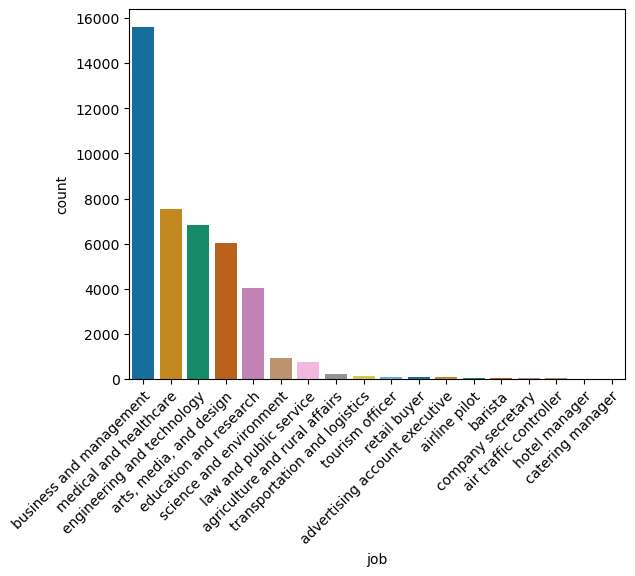

In [21]:
# Create category counts
job_value_counts = cc_df['job'].value_counts().head(20)

# Convert the Series to a DataFrame for easier plotting
category_df = job_value_counts.reset_index()
category_df.columns = ['job', 'count']

# Plot
sns.barplot(x='job', y='count', data=category_df, hue='job', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### DOB

It would be nice if we were able to see the age of the user as well as what generation they belong in. Seeing this could help to see if there are different spending habits amongst the users. 

In [22]:
# Calculate age
cc_df['age'] = datetime.now().year - cc_df['dob'].dt.year

In [23]:
# Create a function to define age groups
def age_group(age):
    if age < 10:
        return 'Gen Alpha'
    elif age < 26:
        return 'Gen Z'
    elif age < 42:
        return 'Millennial'
    elif age < 58:
        return 'Gen X'
    elif age < 77:
        return 'Baby Boomer'
    else:
        return 'Silent Generation'

# Apply the function
cc_df['age_group'] = cc_df['age'].apply(age_group)

/var/folders/1m/xn6n7t396ts_bvsd56hkwp4c0000gn/T/ipykernel_4994/2465565746.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x='age_group', y='count', data=category_df, hue='age_group', palette=sns.color_palette("colorblind"))


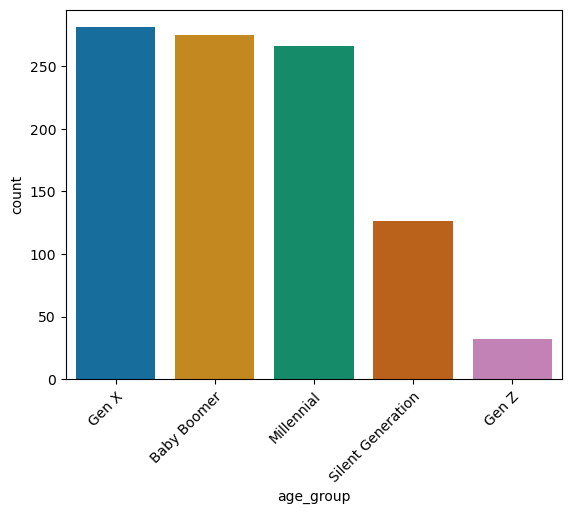

In [24]:
# Aggregate data by cc_num to get unique users
unique_users = cc_df.drop_duplicates(subset=['cc_num'])

# Create category counts based on unique users
age_group_value_counts = unique_users['age_group'].value_counts()

# Convert the Series to a DataFrame for easier plotting
category_df = age_group_value_counts.reset_index()
category_df.columns = ['age_group', 'count']

# Plot
sns.barplot(x='age_group', y='count', data=category_df, hue='age_group', palette=sns.color_palette("colorblind"))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

## MultiColinearity Checks

Inside of the dataset, there are multiple columns that are duplicates of each other. Including all of the features will lead to multicolinearity and as such, this needs to be addressed. 

Duplicate columns:
- locations (customer and merchant)
    - street, city, zip
- age
    - dob, age, age_group

Additionally, there are columns that will not provide useful information to the models. 

- customer name
    - first, last
- transaction number

Lets determine how correlated the features are to each other. 

### Numeric Columns

In [25]:
# List of numerical columns
numeric_features = [
    'amt', 
    'city_pop', 
    'distance_to_merchant', 
    'age', 
    'hour', 
    'day_of_week', 
    'month'
]

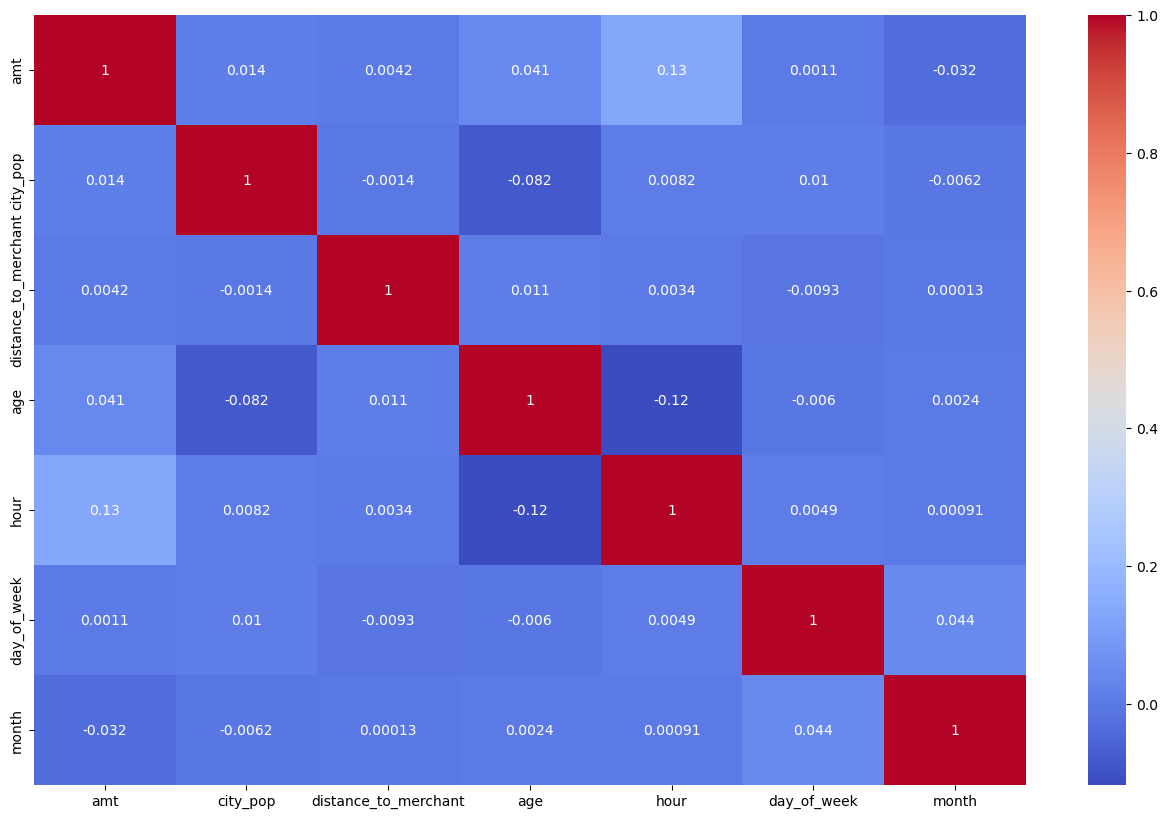

In [26]:
# Calculate correlation matrix
corr_matrix = cc_df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Categorical Columns

In [27]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42464 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cc_num                42464 non-null  object        
 1   category              42464 non-null  object        
 2   amt                   42464 non-null  float64       
 3   first                 42464 non-null  object        
 4   last                  42464 non-null  object        
 5   gender                42464 non-null  object        
 6   street                42464 non-null  object        
 7   city                  42464 non-null  object        
 8   state                 42464 non-null  object        
 9   zip                   42464 non-null  int64         
 10  city_pop              42464 non-null  int64         
 11  job                   42464 non-null  object        
 12  dob                   42464 non-null  datetime64[ns]
 13  trans_num            

In [28]:
# List of categorical columns to be converted
categorical_columns = ['category', 'gender', 'job', 'time_of_day', 'age_group']

# Create dummy variables
cc_df_dummies = pd.get_dummies(cc_df[categorical_columns], drop_first=True)

In [29]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = cc_df_dummies.columns
vif_data['VIF'] = [variance_inflation_factor(cc_df_dummies.values, i) for i in range(cc_df_dummies.shape[1])]

# Filter features with VIF greater than 5
high_vif_features = vif_data[vif_data['VIF'] > 5]

# Print results
if not high_vif_features.empty:
    print("Features with VIF greater than 5:")
    print(high_vif_features)
else:
    print("No multicollinearity detected (all VIFs are less than 5).")

No multicollinearity detected (all VIFs are less than 5).
